In [3]:
# %% Imports
import os, ast, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %% Config
CSV_PATH = "sweep_summary.csv"    # change if needed
FIG_DIR  = "./sweep_figs"
os.makedirs(FIG_DIR, exist_ok=True)

# %% Load
df = pd.read_csv(CSV_PATH)

In [4]:
# Coerce booleans & numerics where helpful
num_cols = [
    "epochs","batch_size","grad_accum_steps","head_lr","encoder_lr",
    "warmup_ratio","best_epoch","best_val_auc","best_val_acc_bestJ",
    "best_val_balacc_bestJ","best_val_loss","best_thr_bestJ",
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# normalize text categories
for c in ["imbalance_mode","unfreeze_mode"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

# optionally parse the unfreeze schedule to something readable (not used in plots below)
def parse_sched(x):
    try:
        return ast.literal_eval(x)
    except Exception:
        return None
if "unfreeze_schedule" in df.columns:
    df["unfreeze_schedule_parsed"] = df["unfreeze_schedule"].apply(parse_sched)

# quick sanity
print("Rows:", len(df))
print("Columns:", list(df.columns))

Rows: 72
Columns: ['run_slug', 'epochs', 'batch_size', 'grad_accum_steps', 'head_lr', 'encoder_lr', 'warmup_ratio', 'imbalance_mode', 'unfreeze_mode', 'amp', 'unfreeze_schedule', 'best_epoch', 'best_val_auc', 'best_val_acc_bestJ', 'best_val_balacc_bestJ', 'best_val_loss', 'best_thr_bestJ', 'unfreeze_schedule_parsed']


In [6]:
def savefig(name):
    path = os.path.join(FIG_DIR, name)
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=150)
    plt.show()
    print(f"saved {path}")

In [ ]:
def summarize(df):
    out = {}

    # overall best runs
    top = df.sort_values("best_val_auc", ascending=False).head(5)
    out["best_runs"] = top[["run_slug","best_val_auc","best_val_loss","best_val_balacc_bestJ","head_lr","encoder_lr","grad_accum_steps","warmup_ratio","unfreeze_mode"]]

    # effect: prelast2 vs staged on AUC
    if "unfreeze_mode" in df.columns:
        out["auc_by_unfreeze"] = df.groupby("unfreeze_mode")["best_val_auc"].agg(["mean","std","count"]).sort_values("mean", ascending=False)

    # effect: encoder_lr strata (median AUC)
    out["auc_by_encoder_lr"] = df.groupby("encoder_lr")["best_val_auc"].agg(["mean","median","std","count"]).sort_values("median", ascending=False)

    # effect: head_lr strata (median AUC)
    out["auc_by_head_lr"] = df.groupby("head_lr")["best_val_auc"].agg(["mean","median","std","count"]).sort_values("median", ascending=False)

    # effect: accumulation
    out["auc_by_accum"] = df.groupby("grad_accum_steps")["best_val_auc"].agg(["mean","median","std","count"]).sort_values("median", ascending=False)

    # warmup effect (median AUC)
    out["auc_by_warmup"] = df.groupby("warmup_ratio")["best_val_auc"].agg(["mean","median","std","count"]).sort_values("median", ascending=False)

    # top combo table (encoder_lr x head_lr)
    pivot = df.pivot_table(index="encoder_lr", columns="head_lr", values="best_val_auc", aggfunc="median")
    out["auc_heatmap_table"] = pivot

    # consistency: best_epoch distribution
    out["best_epoch_desc"] = df["best_epoch"].describe()

    # brief text summary
    txt = []

    # best run headline
    br = top.iloc[0]
    txt.append(f"Best AUROC: {br.best_val_auc:.3f} (loss {br.best_val_loss:.3f}, bal-acc {br.best_val_balacc_bestJ:.3f}) "
               f"@ enc_lr={br.encoder_lr:.2e}, head_lr={br.head_lr:.2e}, accum={int(br.grad_accum_steps)}, "
               f"warmup={br.warmup_ratio}, unfreeze={br.unfreeze_mode}, run={br.run_slug}")

    # unfreeze effect
    if "unfreeze_mode" in df.columns:
        g = out["auc_by_unfreeze"]
        best_mode = g["mean"].idxmax()
        txt.append(f"Unfreeze mode (mean AUROC): {g['mean'].to_dict()}. Best on average: {best_mode}.")

    # lr sweet spots
    best_enc = out["auc_by_encoder_lr"].reset_index().iloc[0]
    txt.append(f"Encoder LR sweet spot (median AUROC): {best_enc['encoder_lr']:.2e} → median {best_enc['median']:.3f}.")

    best_head = out["auc_by_head_lr"].reset_index().iloc[0]
    txt.append(f"Head LR sweet spot (median AUROC): {best_head['head_lr']:.2e} → median {best_head['median']:.3f}.")

    # accum effect
    best_acc = out["auc_by_accum"].reset_index().iloc[0]
    txt.append(f"Grad accumulation: {int(best_acc['grad_accum_steps'])} has highest median AUROC {best_acc['median']:.3f}.")

    # warmup effect
    best_warm = out["auc_by_warmup"].reset_index().iloc[0]
    txt.append(f"Warmup ratio: {best_warm['warmup_ratio']} has highest median AUROC {best_warm['median']:.3f}.")

    # epoch behavior
    desc = out["best_epoch_desc"]
    txt.append(f"Best epoch distribution — median: {desc['50%']:.1f}, mean: {desc['mean']:.1f}, min: {desc['min']:.0f}, max: {desc['max']:.0f} "
               "(if best epoch is early, risk of slightly overtraining).")

    print("\n=== KEY INSIGHTS ===")
    for line in txt:
        print("-", line)

    print("\nTop 5 runs by AUROC:")
    print(out["best_runs"].to_string(index=False))

    if "unfreeze_mode" in df.columns:
        print("\nMean/Std/Count AUROC by unfreeze mode:")
        print(out["auc_by_unfreeze"])

    print("\nMedian AUROC by encoder_lr:")
    print(out["auc_by_encoder_lr"])

    print("\nMedian AUROC by head_lr:")
    print(out["auc_by_head_lr"])

    print("\nMedian AUROC by grad_accum_steps:")
    print(out["auc_by_accum"])

    print("\nMedian AUROC by warmup_ratio:")
    print(out["auc_by_warmup"])

    print("\nEncoder_lr x Head_lr (median AUROC) table:")
    print(out["auc_heatmap_table"])

In [7]:

summarize(df)


=== KEY INSIGHTS ===
- Best AUROC: 0.869 (loss 0.718, bal-acc 0.817) @ enc_lr=3.00e-05, head_lr=1.00e-04, accum=1, warmup=0.05, unfreeze=prelast2, run=accum_1__bs_8__elr_3.00e-05__ep_10__hlr_1.00e-04__imb_pos_weight__sched_2_11-4_10__warm_0.0500
- Unfreeze mode (mean AUROC): {'prelast2': 0.8324845679012346, 'staged': 0.8292824074074074}. Best on average: prelast2.
- Encoder LR sweet spot (median AUROC): 3.00e-05 → median 0.849.
- Head LR sweet spot (median AUROC): 1.00e-04 → median 0.839.
- Grad accumulation: 1 has highest median AUROC 0.839.
- Warmup ratio: 0.1 has highest median AUROC 0.831.
- Best epoch distribution — median: 9.0, mean: 8.3, min: 1, max: 10 (if best epoch is early, you may be slightly overtraining).

Top 5 runs by AUROC:
                                                                                      run_slug  best_val_auc  best_val_loss  best_val_balacc_bestJ  head_lr  encoder_lr  grad_accum_steps  warmup_ratio unfreeze_mode
accum_1__bs_8__elr_3.00e-05__ep_10

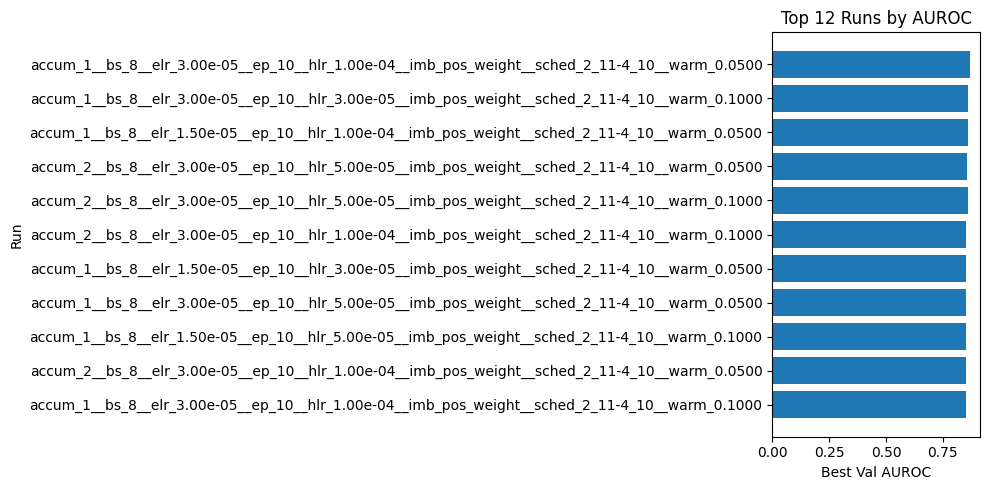

saved ./sweep_figs/top_runs_auroc.png


In [8]:
# %% PLOT 1 — Top-N runs by AUROC (bar)
TOP_N = 12
topn = df.sort_values("best_val_auc", ascending=False).head(TOP_N).copy()
plt.figure(figsize=(10, 5))
plt.barh(topn["run_slug"][::-1], topn["best_val_auc"][::-1])
plt.xlabel("Best Val AUROC")
plt.ylabel("Run")
plt.title(f"Top {TOP_N} Runs by AUROC")
savefig("top_runs_auroc.png")



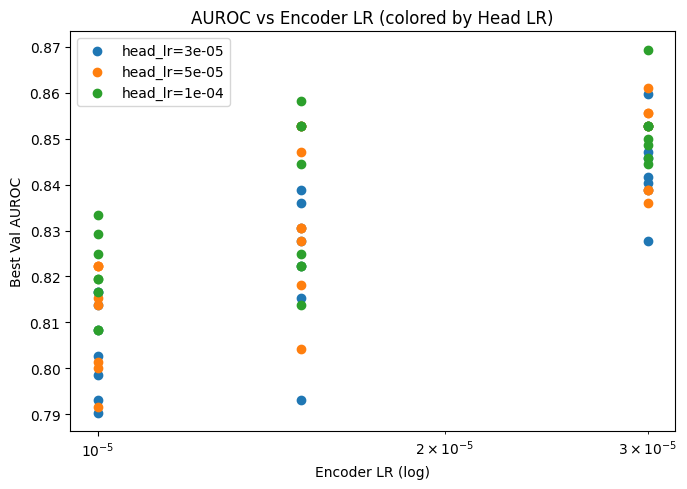

saved ./sweep_figs/auc_vs_encoder_lr_by_head_lr.png


In [9]:
# %% PLOT 2 — AUROC vs Encoder LR, faceted by Head LR (markers)
plt.figure(figsize=(7, 5))
for hlr, g in df.groupby("head_lr"):
    xs = g["encoder_lr"].values
    ys = g["best_val_auc"].values
    plt.scatter(xs, ys, label=f"head_lr={hlr:.0e}")
plt.xscale("log")
plt.xlabel("Encoder LR (log)")
plt.ylabel("Best Val AUROC")
plt.title("AUROC vs Encoder LR (colored by Head LR)")
plt.legend()
savefig("auc_vs_encoder_lr_by_head_lr.png")

/var/folders/yt/tz83drvd007b5tm1jvh0w1mw0000gn/T/ipykernel_22860/1397752352.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=modes, showmeans=True)


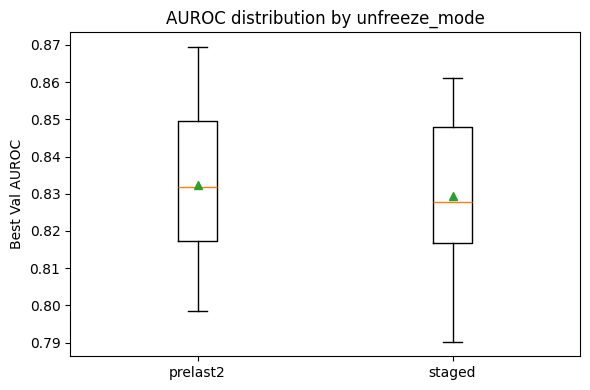

saved ./sweep_figs/box_auc_by_unfreeze_mode.png


In [10]:
# %% PLOT 3 — Boxplot AUROC by unfreeze_mode
if "unfreeze_mode" in df.columns:
    modes = df["unfreeze_mode"].unique().tolist()
    data = [df.loc[df["unfreeze_mode"]==m,"best_val_auc"].dropna().values for m in modes]
    plt.figure(figsize=(6, 4))
    plt.boxplot(data, labels=modes, showmeans=True)
    plt.ylabel("Best Val AUROC")
    plt.title("AUROC distribution by unfreeze_mode")
    savefig("box_auc_by_unfreeze_mode.png")

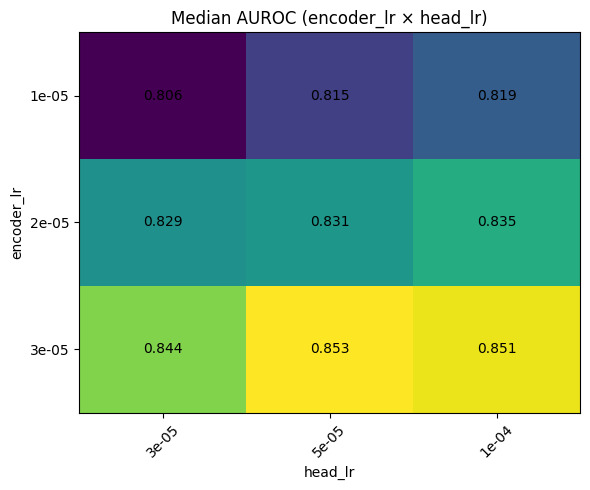

saved ./sweep_figs/heatmap_median_auc_encoder_head.png


In [ ]:
# %% PLOT 4 — Heatmap-like grid (encoder_lr × head_lr → median AUROC)
# (Matplotlib pcolor from a pivot)
pivot = df.pivot_table(index="encoder_lr", columns="head_lr", values="best_val_auc", aggfunc="median")
plt.figure(figsize=(6, 5))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), [f"{c:.0e}" for c in pivot.columns], rotation=45)
plt.yticks(range(len(pivot.index)),   [f"{i:.0e}" for i in pivot.index])
plt.xlabel("head_lr")
plt.ylabel("encoder_lr")
plt.title("Median AUROC (encoder_lr x head_lr)")
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        if pd.notna(val):
            plt.text(j, i, f"{val:.3f}", ha="center", va="center")
# get todays date 
today = pd.Timestamp.now().strftime("%Y%m%d")
savefig(f"heatmap_median_auc_encoder_head_{today}.png")